# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band12.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.961792 -0.311972 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.961792 -0.311972 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.961792 -0.311972 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.961792 -0.311972 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.961792 -0.311972 -0.969108 -1.0 -1.0 -1.0 -1.0   

                    9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.846424   
      201547 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.846424   
      201548 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.846424   
      201549 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.846424   
      201550 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.846424   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.935955  -1.0 -0.861740  
      201547  -1.0 -0.935955  -1.0 -0.854589  
      201548  -1.0 -0.935955  -1.0 -0.856973  
      201549  -1.0 -0.935955  -1.0 -0.856973  
      201550  -1.0 -0.935955  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4    5         6  \
41001 201820 -1.000000 -0.978833 -0.968522 -1.000000 -1.000000 -1.0 -0.970848   
      201821 -1.000000 -0.993813 -1.000000 -1.000000 -0.922226 -1.0  0.532902   
      201822 -1.000000 -0.747939 -0.976032 -1.000000 -0.933930 -1.0 -0.928931   
      201823 -1.000000 -0.824471 -0.932122 -0.975373 -0.953865 -1.0 -0.965664   
      201824 -0.999096 -1.000000 -0.970792 -1.000000 -1.000000 -1.0 -0.286342   

                     7         8         9  ...  2039      2040      2041  \
41001 201820 -1.000000 -0.930819 -1.000000  ...  -1.0 -0.589339 -1.000000   
      201821 -1.000000 -0.965616 -0.911632  ...  -1.0 -0.527377 -0.511568   
      201822 -0.894265 -0.935521 -0.848443  ...  -1.0 -0.381208 -0.431550   
      201823 -1.000000 -1.000000 -1.000000  ...  -1.0 -0.968794 -1.000000   
      201824 -1.000000 -0.976864 -1.000000  ...  -1.0 -0.689433 -1.000000   

                 2042      2043      2044  2045      2046      2047    Labels  
41001 201820 -0.97837 -0.976630 -0.971215  -1.0 -0.952435 -1.000000 -0.949940  
      201821 -1.00000 -0.519101 -0.847790  -1.0 -0.804923 -1.000000 -0.961859  
      201822 -1.00000 -0.580586 -0.950785  -1.0 -0.677856 -1.000000 -0.940405  
      201823 -1.00000 -0.987271 -0.992014  -1.0 -0.960301 -1.000000 -0.961859  
      201824 -1.00000 -0.991391 -0.959401  -1.0  0.117789 -0.985283 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

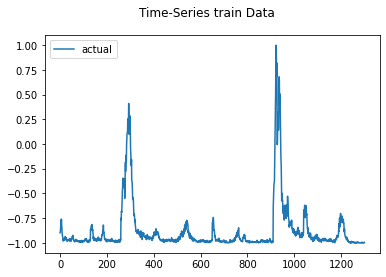

2023-03-07 14:53:32.262384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:53:32.262450: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:53:32.262486: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 14:53:32.262935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:53:32.686010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 48.858
Test RMSE: 63.722
Test sMAPE: 123.199
Test R Squared: -3.202
{'mae': 48.85845292337013, 'rmse': 63.72189488579106, 'smape': 123.19904549479543, 'r2': -3.2016450928987137}


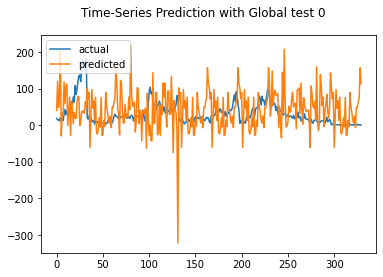

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 53.863
Test RMSE: 74.419
Test sMAPE: 112.561
Test R Squared: -4.731
{'mae': 53.86308539961323, 'rmse': 74.4189140229302, 'smape': 112.56076019150893, 'r2': -4.730712985912265}


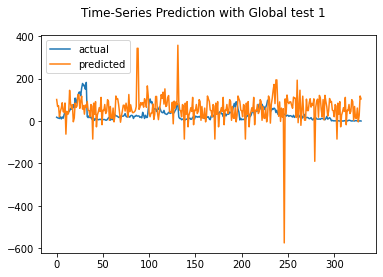

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 44.684
Test RMSE: 54.295
Test sMAPE: 103.965
Test R Squared: -2.050
{'mae': 44.683682817040065, 'rmse': 54.29462996897476, 'smape': 103.96502717124456, 'r2': -2.0503927282794767}


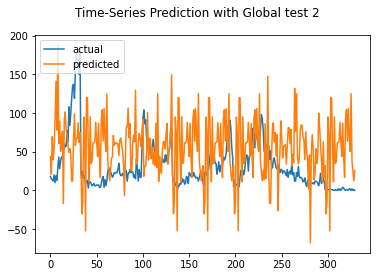

Test MAE: 66.503
Test RMSE: 75.054
Test sMAPE: 117.590
Test R Squared: -4.829
{'mae': 66.5030072848002, 'rmse': 75.0535121481903, 'smape': 117.58980782433436, 'r2': -4.828865599927652}


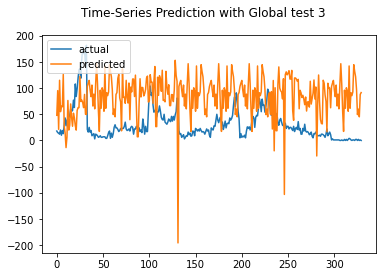

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 75.878
Test RMSE: 115.100
Test sMAPE: 126.350
Test R Squared: -12.709
{'mae': 75.87828917593667, 'rmse': 115.09996174314897, 'smape': 126.35037303865165, 'r2': -12.708576508700684}


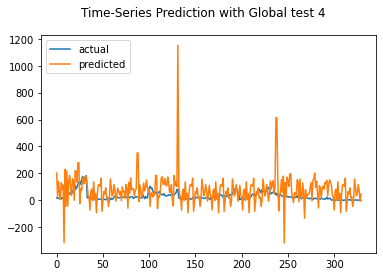

Test MAE: 47.943
Test RMSE: 94.322
Test sMAPE: 98.724
Test R Squared: -8.206
{'mae': 47.943494484641334, 'rmse': 94.32151598437547, 'smape': 98.72395332710465, 'r2': -8.205842626242784}


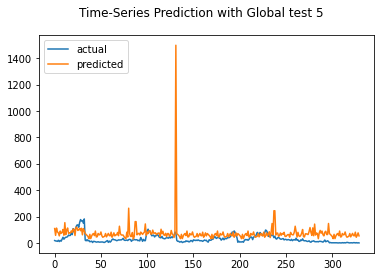

Test MAE: 72.264
Test RMSE: 93.946
Test sMAPE: 138.730
Test R Squared: -8.133
{'mae': 72.26361939527771, 'rmse': 93.9460888509432, 'smape': 138.73021964857384, 'r2': -8.132704596532532}


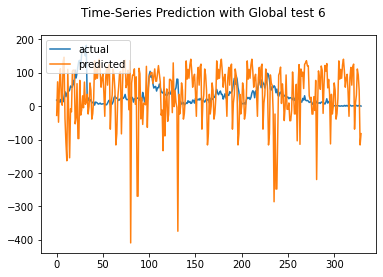

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 74.290
Test RMSE: 94.067
Test sMAPE: 128.102
Test R Squared: -8.156
{'mae': 74.29001718578917, 'rmse': 94.06669183010284, 'smape': 128.10224817137905, 'r2': -8.15616780559305}


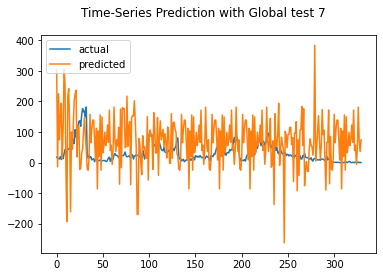

Test MAE: 32.214
Test RMSE: 53.459
Test sMAPE: 90.576
Test R Squared: -1.957
{'mae': 32.214440590143205, 'rmse': 53.45871805113451, 'smape': 90.57620748600564, 'r2': -1.9571889985440074}


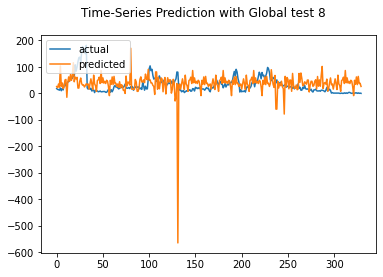

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 73.345
Test RMSE: 102.290
Test sMAPE: 128.312
Test R Squared: -9.827
{'mae': 73.3445356238972, 'rmse': 102.29035786641067, 'smape': 128.3121087151918, 'r2': -9.827081294738472}


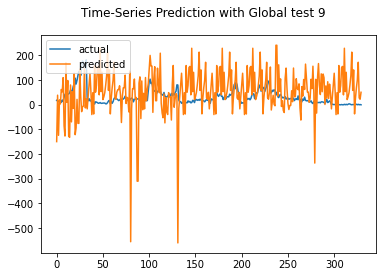

Test MAE: 78.739
Test RMSE: 101.426
Test sMAPE: 121.710
Test R Squared: -9.645
{'mae': 78.73852795109605, 'rmse': 101.42610122906426, 'smape': 121.70979237906823, 'r2': -9.644897038457406}


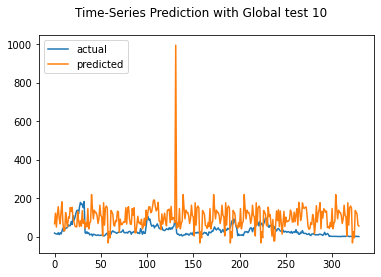

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 127.176
Test RMSE: 172.899
Test sMAPE: 141.236
Test R Squared: -29.933
{'mae': 127.17621252609021, 'rmse': 172.89914963190537, 'smape': 141.2359572134723, 'r2': -29.933404186180816}


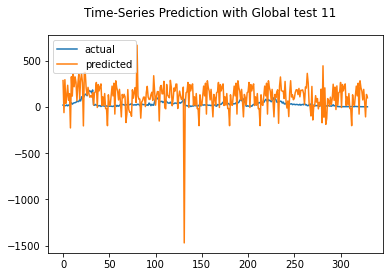

Test MAE: 40.854
Test RMSE: 52.594
Test sMAPE: 101.081
Test R Squared: -1.862
{'mae': 40.854100821957445, 'rmse': 52.59370917870316, 'smape': 101.081094015391, 'r2': -1.8622634366761006}


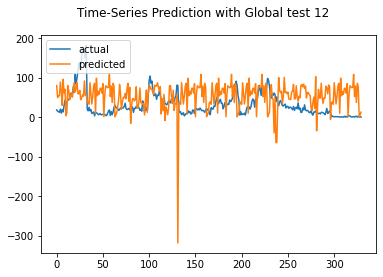

Test MAE: 92.347
Test RMSE: 160.131
Test sMAPE: 119.848
Test R Squared: -25.533
{'mae': 92.34734250559951, 'rmse': 160.13105832855643, 'smape': 119.84758836166698, 'r2': -25.533414992695903}


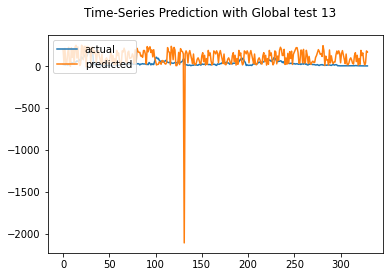

Test MAE: 58.351
Test RMSE: 102.639
Test sMAPE: 122.075
Test R Squared: -9.901
{'mae': 58.3514673473257, 'rmse': 102.63887583780198, 'smape': 122.07525301277893, 'r2': -9.900985830834076}


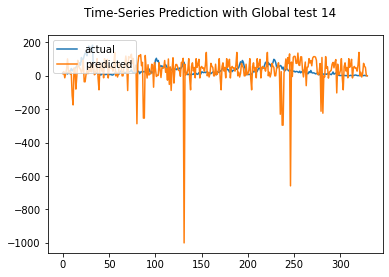

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 87.612
Test RMSE: 114.083
Test sMAPE: 138.200
Test R Squared: -12.467
{'mae': 87.6123485218395, 'rmse': 114.08269161419541, 'smape': 138.20005748626082, 'r2': -12.46733055553226}


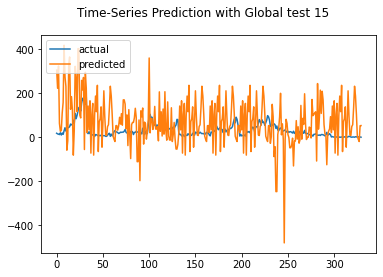

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 69.976
Test RMSE: 91.797
Test sMAPE: 130.657
Test R Squared: -7.720
{'mae': 69.97623759472009, 'rmse': 91.79687407346479, 'smape': 130.6574921116657, 'r2': -7.719624577178983}


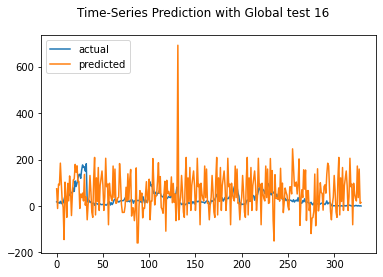

Test MAE: 68.577
Test RMSE: 142.107
Test sMAPE: 113.921
Test R Squared: -19.897
{'mae': 68.57683806311, 'rmse': 142.1073665391706, 'smape': 113.92129488086454, 'r2': -19.896578582356355}


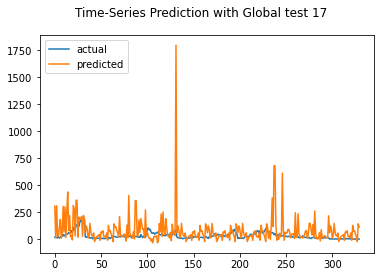

Test MAE: 61.908
Test RMSE: 89.028
Test sMAPE: 110.069
Test R Squared: -7.202
{'mae': 61.90840062589356, 'rmse': 89.02823363805307, 'smape': 110.06935337307324, 'r2': -7.201579809636671}


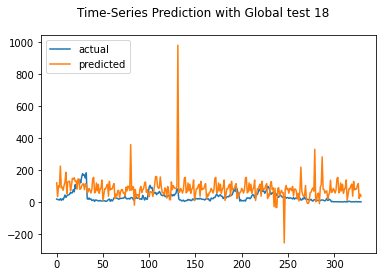

Test MAE: 51.318
Test RMSE: 81.854
Test sMAPE: 112.855
Test R Squared: -5.933
{'mae': 51.317914911833675, 'rmse': 81.85364412594048, 'smape': 112.85453144746242, 'r2': -5.932949545256665}


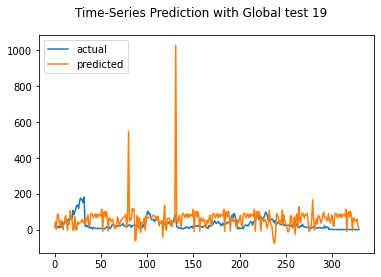

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 57.383
Test RMSE: 82.877
Test sMAPE: 137.265
Test R Squared: -6.107
{'mae': 57.38300060973023, 'rmse': 82.87672354146822, 'smape': 137.2654663014147, 'r2': -6.107340925958268}


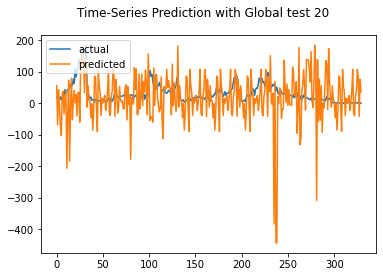

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 56.756
Test RMSE: 71.994
Test sMAPE: 118.735
Test R Squared: -4.363
{'mae': 56.75586490324049, 'rmse': 71.99443902804049, 'smape': 118.73499615692744, 'r2': -4.363396519599367}


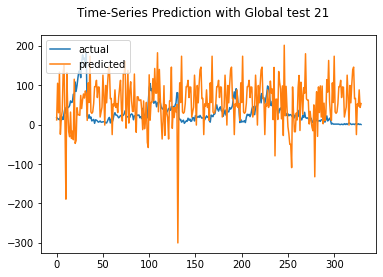

Test MAE: 94.386
Test RMSE: 265.749
Test sMAPE: 128.328
Test R Squared: -72.078
{'mae': 94.38590790900317, 'rmse': 265.7487511335787, 'smape': 128.32808529712847, 'r2': -72.07763202019747}


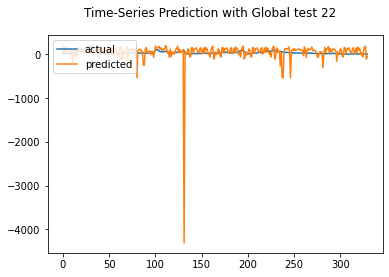

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 99.996
Test RMSE: 129.779
Test sMAPE: 132.818
Test R Squared: -16.428
{'mae': 99.99562235899043, 'rmse': 129.7793316617419, 'smape': 132.81777840062466, 'r2': -16.42822139533424}


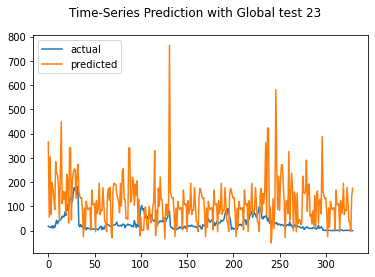

Test MAE: 45.070
Test RMSE: 65.276
Test sMAPE: 108.873
Test R Squared: -3.409
{'mae': 45.07015545837807, 'rmse': 65.27583076480651, 'smape': 108.87315516798893, 'r2': -3.4090682065887785}


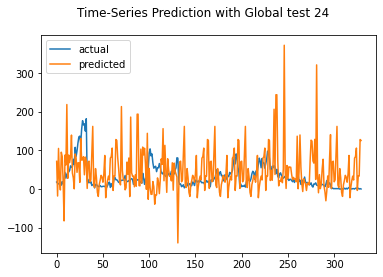

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 108.578
Test RMSE: 162.235
Test sMAPE: 136.816
Test R Squared: -26.235
{'mae': 108.57767394889484, 'rmse': 162.23480631569043, 'smape': 136.81564314878045, 'r2': -26.235168776819254}


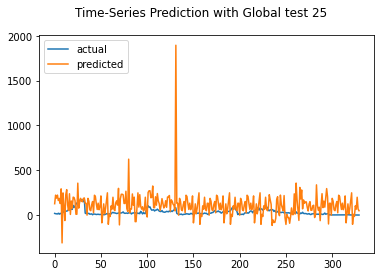

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 79.072
Test RMSE: 100.845
Test sMAPE: 131.934
Test R Squared: -9.523
{'mae': 79.07239908277988, 'rmse': 100.84530534512005, 'smape': 131.93432177993546, 'r2': -9.523334425637165}


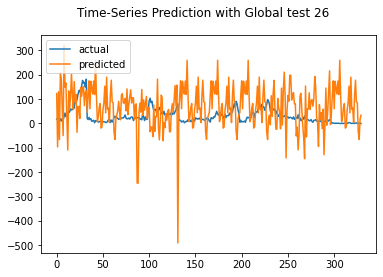

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.553
Test RMSE: 66.722
Test sMAPE: 102.951
Test R Squared: -3.607
{'mae': 46.55306918223699, 'rmse': 66.72232667519971, 'smape': 102.95143414225225, 'r2': -3.606640972932839}


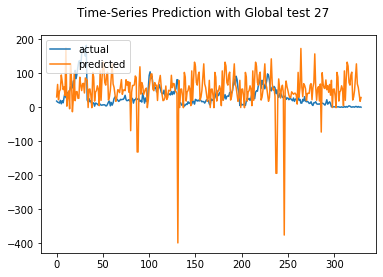

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 55.673
Test RMSE: 78.585
Test sMAPE: 109.293
Test R Squared: -5.390
{'mae': 55.672527086373535, 'rmse': 78.58486818732243, 'smape': 109.29261175978324, 'r2': -5.390279586581872}


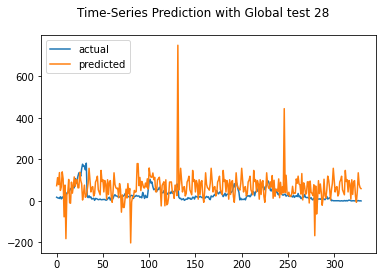

Test MAE: 91.496
Test RMSE: 180.781
Test sMAPE: 128.665
Test R Squared: -32.818
{'mae': 91.4958716687831, 'rmse': 180.78141480142799, 'smape': 128.66481624315628, 'r2': -32.81812798623164}


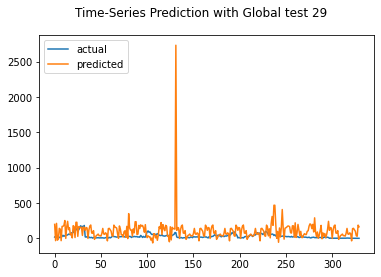

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 70.458
Test RMSE: 86.799
Test sMAPE: 118.495
Test R Squared: -6.796
{'mae': 70.45805298993082, 'rmse': 86.79896764377428, 'smape': 118.494699839699, 'r2': -6.795987271758462}


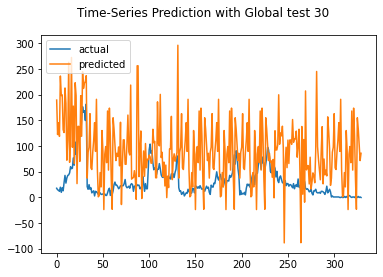

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 40.880
Test RMSE: 61.118
Test sMAPE: 99.959
Test R Squared: -2.865
{'mae': 40.87986768267371, 'rmse': 61.118118937890905, 'smape': 99.95861216180924, 'r2': -2.865288905826385}


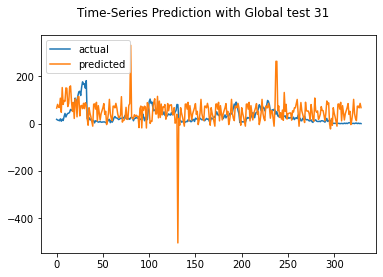

Test MAE: 65.141
Test RMSE: 93.573
Test sMAPE: 110.902
Test R Squared: -8.060
{'mae': 65.14098819566496, 'rmse': 93.57282614732068, 'smape': 110.90229329355489, 'r2': -8.060277399091753}


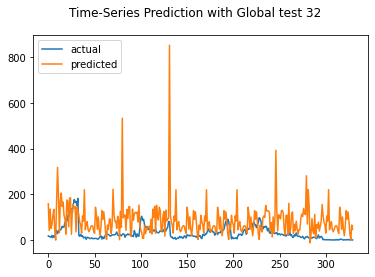

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 59.480
Test RMSE: 83.418
Test sMAPE: 137.147
Test R Squared: -6.200
{'mae': 59.480362099950966, 'rmse': 83.4179616294148, 'smape': 137.14672451627789, 'r2': -6.200475025941309}


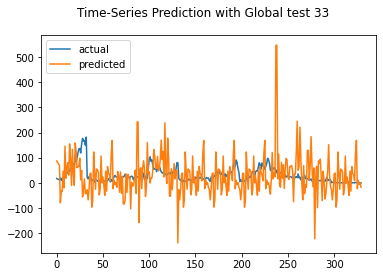

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 41.620
Test RMSE: 69.655
Test sMAPE: 105.117
Test R Squared: -4.021
{'mae': 41.61958216627439, 'rmse': 69.65542818580181, 'smape': 105.11707432904562, 'r2': -4.020557370660789}


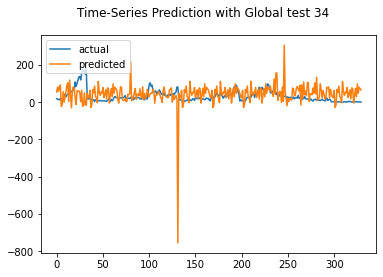

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 84.621
Test RMSE: 134.035
Test sMAPE: 128.552
Test R Squared: -17.590
{'mae': 84.62135162714756, 'rmse': 134.035381660107, 'smape': 128.5521125436531, 'r2': -17.590065171842806}


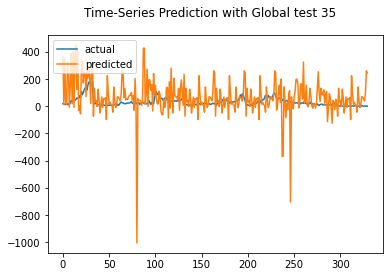

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 81.381
Test RMSE: 110.858
Test sMAPE: 139.832
Test R Squared: -11.717
{'mae': 81.38117419138099, 'rmse': 110.85760983866811, 'smape': 139.83201729706497, 'r2': -11.716658920943184}


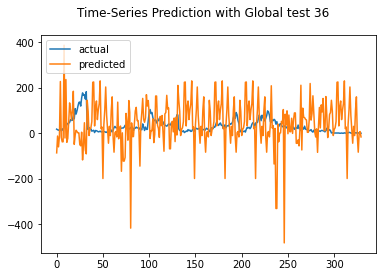

Test MAE: 39.124
Test RMSE: 52.900
Test sMAPE: 94.156
Test R Squared: -1.896
{'mae': 39.12425302736687, 'rmse': 52.89995641190148, 'smape': 94.1555234736046, 'r2': -1.8956937585767757}


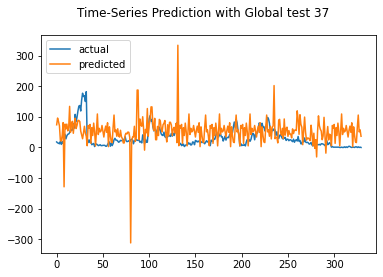

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 60.659
Test RMSE: 96.384
Test sMAPE: 135.795
Test R Squared: -8.613
{'mae': 60.65899887112054, 'rmse': 96.38407385635485, 'smape': 135.79460030685578, 'r2': -8.612858706606387}


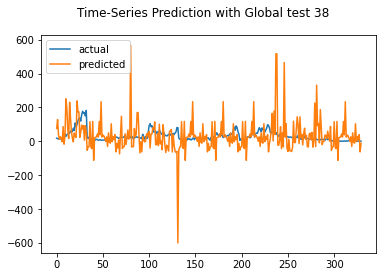

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 61.886
Test RMSE: 80.244
Test sMAPE: 122.968
Test R Squared: -5.663
{'mae': 61.88623179016691, 'rmse': 80.24385156332885, 'smape': 122.9684916615315, 'r2': -5.662934338474097}


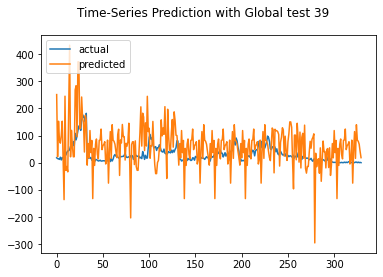

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 63.462
Test RMSE: 92.966
Test sMAPE: 137.450
Test R Squared: -7.943
{'mae': 63.46232005565455, 'rmse': 92.96607000481414, 'smape': 137.45046947750137, 'r2': -7.943158876368853}


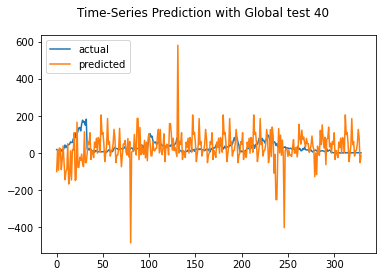

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 97.169
Test RMSE: 125.055
Test sMAPE: 158.784
Test R Squared: -15.182
{'mae': 97.16906868616739, 'rmse': 125.05509892960718, 'smape': 158.78421266663452, 'r2': -15.182469975022414}


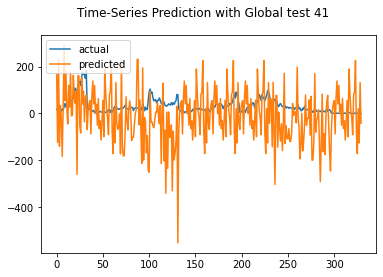

Test MAE: 50.578
Test RMSE: 61.990
Test sMAPE: 107.269
Test R Squared: -2.976
{'mae': 50.57826205744888, 'rmse': 61.98986330162853, 'smape': 107.26928106365142, 'r2': -2.9763385990137357}


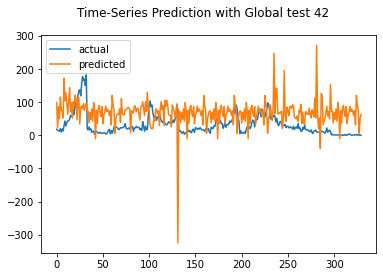

Test MAE: 78.968
Test RMSE: 96.329
Test sMAPE: 119.774
Test R Squared: -8.602
{'mae': 78.96839700756651, 'rmse': 96.32868706527974, 'smape': 119.77441430622632, 'r2': -8.601813885667214}


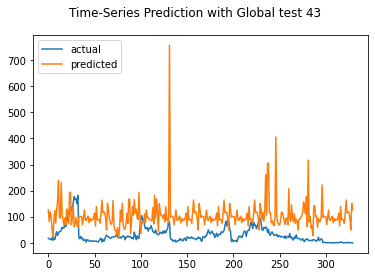

Test MAE: 87.241
Test RMSE: 201.966
Test sMAPE: 133.958
Test R Squared: -41.208
{'mae': 87.24122121153455, 'rmse': 201.96627202335432, 'smape': 133.95833881224516, 'r2': -41.208478760549134}


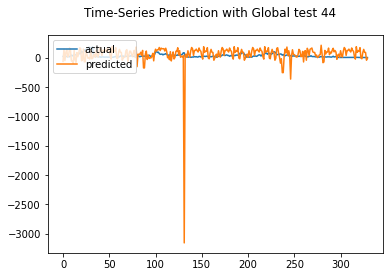

Test MAE: 63.741
Test RMSE: 133.747
Test sMAPE: 134.117
Test R Squared: -17.510
{'mae': 63.74149567141677, 'rmse': 133.7466590780674, 'smape': 134.11670591547153, 'r2': -17.510062553378464}


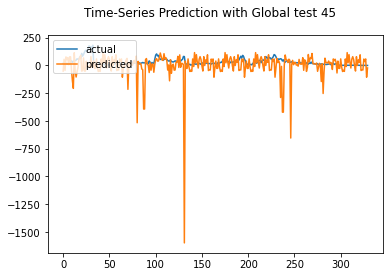

Test MAE: 56.729
Test RMSE: 78.948
Test sMAPE: 104.442
Test R Squared: -5.449
{'mae': 56.72850598421964, 'rmse': 78.94759708576161, 'smape': 104.44182161499506, 'r2': -5.449407728019001}


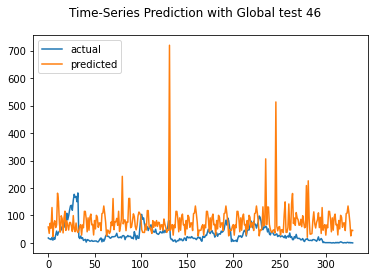

Test MAE: 107.729
Test RMSE: 244.438
Test sMAPE: 140.792
Test R Squared: -60.827
{'mae': 107.72927522948294, 'rmse': 244.43765950981805, 'smape': 140.79220755568835, 'r2': -60.82700869847232}


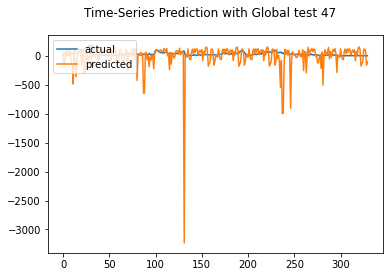

Test MAE: 60.756
Test RMSE: 84.478
Test sMAPE: 118.456
Test R Squared: -6.385
{'mae': 60.75617189172542, 'rmse': 84.47786329216463, 'smape': 118.45576336079067, 'r2': -6.384614743114881}


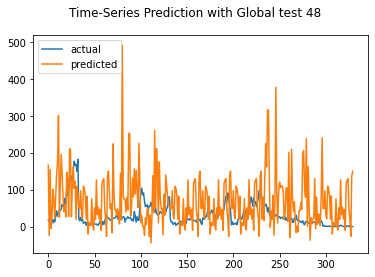

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 101.148
Test RMSE: 123.634
Test sMAPE: 140.189
Test R Squared: -14.817
{'mae': 101.14755710236955, 'rmse': 123.6339740266772, 'smape': 140.1891468461084, 'r2': -14.816764927235191}


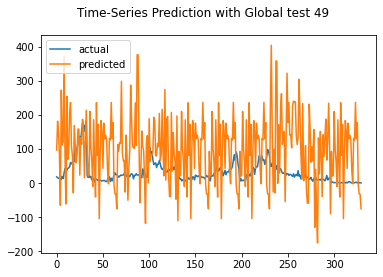

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 59.792
Test RMSE: 93.893
Test sMAPE: 121.240
Test R Squared: -8.122
{'mae': 59.79161667227745, 'rmse': 93.89291069395112, 'smape': 121.24008336443053, 'r2': -8.122368393061594}


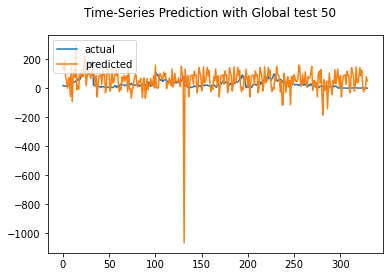

Test MAE: 55.066
Test RMSE: 80.948
Test sMAPE: 104.693
Test R Squared: -5.780
{'mae': 55.06597275878444, 'rmse': 80.94838050418136, 'smape': 104.69292296555341, 'r2': -5.780447077391807}


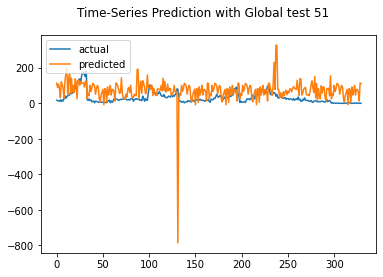

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 35.105
Test RMSE: 51.920
Test sMAPE: 99.123
Test R Squared: -1.789
{'mae': 35.105171989852735, 'rmse': 51.919998168251674, 'smape': 99.12256544978288, 'r2': -1.789403481419774}


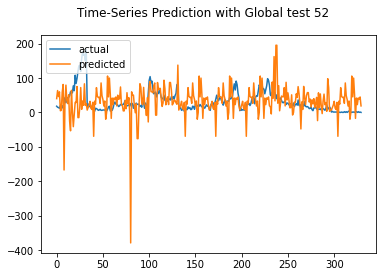

Test MAE: 50.633
Test RMSE: 66.593
Test sMAPE: 102.259
Test R Squared: -3.589
{'mae': 50.63289665308866, 'rmse': 66.59323755242613, 'smape': 102.25884145123696, 'r2': -3.5888330812129112}


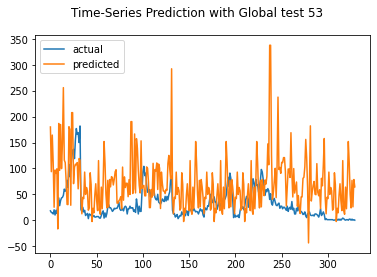

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 53.336
Test RMSE: 66.317
Test sMAPE: 143.983
Test R Squared: -3.551
{'mae': 53.33566779837464, 'rmse': 66.31692538265519, 'smape': 143.98325776051095, 'r2': -3.5508316279561454}


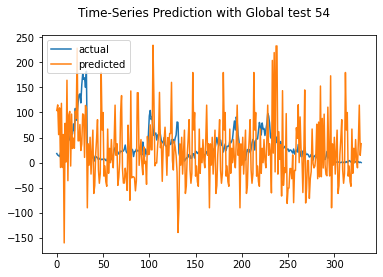

Test MAE: 85.439
Test RMSE: 145.977
Test sMAPE: 128.143
Test R Squared: -21.050
{'mae': 85.43893761237463, 'rmse': 145.97670034461058, 'smape': 128.1432713319968, 'r2': -21.050025037596004}


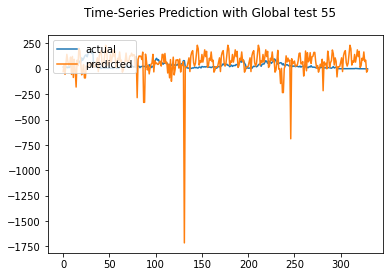

Test MAE: 58.122
Test RMSE: 99.758
Test sMAPE: 120.566
Test R Squared: -9.298
{'mae': 58.121593138846485, 'rmse': 99.75761607415158, 'smape': 120.56551422987324, 'r2': -9.297555137320984}


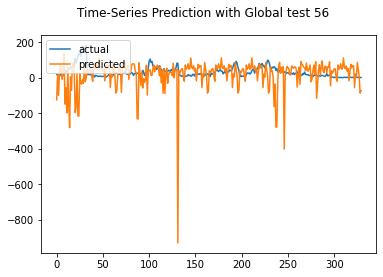

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 82.840
Test RMSE: 129.135
Test sMAPE: 138.416
Test R Squared: -16.256
{'mae': 82.83967708746592, 'rmse': 129.13473910915226, 'smape': 138.41578543710364, 'r2': -16.255525133041754}


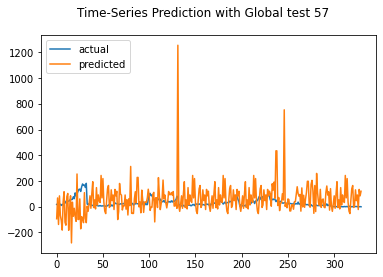

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 72.214
Test RMSE: 115.012
Test sMAPE: 148.030
Test R Squared: -12.688
{'mae': 72.2137467722098, 'rmse': 115.0123710913072, 'smape': 148.0300736710711, 'r2': -12.687720093920722}


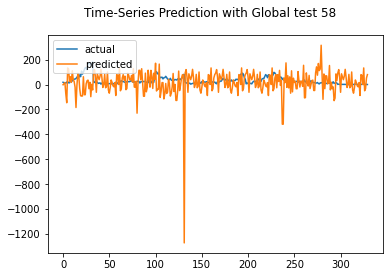

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 82.777
Test RMSE: 103.935
Test sMAPE: 134.432
Test R Squared: -10.178
{'mae': 82.777391542991, 'rmse': 103.93549337665479, 'smape': 134.43216051837848, 'r2': -10.178145687967247}


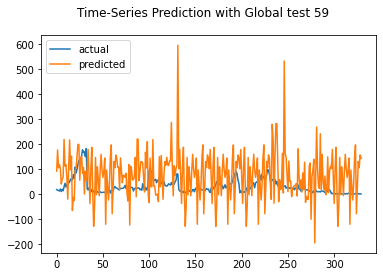

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 63.585
Test RMSE: 91.989
Test sMAPE: 117.934
Test R Squared: -7.756
{'mae': 63.58451993754416, 'rmse': 91.98860946413568, 'smape': 117.93433689526928, 'r2': -7.756087836796569}


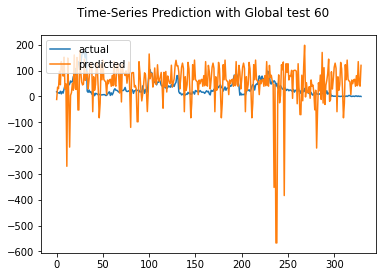

Test MAE: 69.208
Test RMSE: 111.941
Test sMAPE: 114.574
Test R Squared: -11.967
{'mae': 69.20752036427007, 'rmse': 111.94133792007648, 'smape': 114.57446207045554, 'r2': -11.966506683138652}


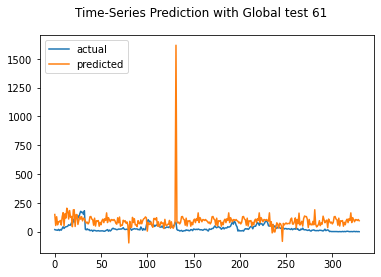

Test MAE: 56.169
Test RMSE: 74.850
Test sMAPE: 112.494
Test R Squared: -4.797
{'mae': 56.16869927030621, 'rmse': 74.85041105218737, 'smape': 112.49381160814993, 'r2': -4.797361486112042}


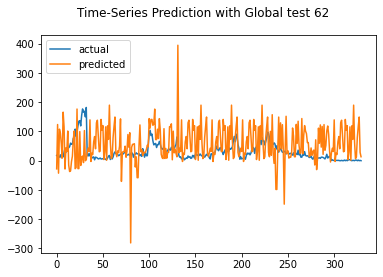

Test MAE: 72.838
Test RMSE: 222.940
Test sMAPE: 104.130
Test R Squared: -50.430
{'mae': 72.83797320163612, 'rmse': 222.94041614726962, 'smape': 104.12985776793732, 'r2': -50.43036619314633}


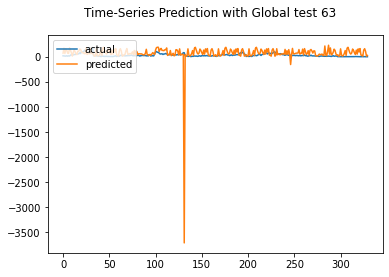

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 83.424
Test RMSE: 139.405
Test sMAPE: 128.282
Test R Squared: -19.109
{'mae': 83.42388345581112, 'rmse': 139.4046759749911, 'smape': 128.2823800187298, 'r2': -19.109287549543797}


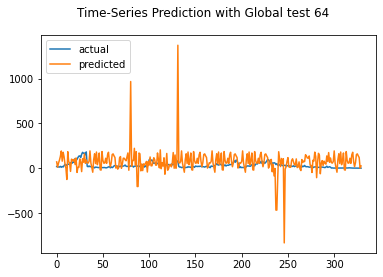

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 53.424
Test RMSE: 96.633
Test sMAPE: 117.592
Test R Squared: -8.663
{'mae': 53.42409470659314, 'rmse': 96.63280094342339, 'smape': 117.59173631819642, 'r2': -8.662536279000914}


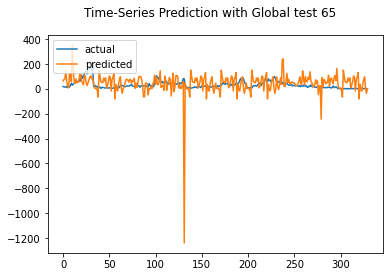

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 82.862
Test RMSE: 115.444
Test sMAPE: 149.592
Test R Squared: -12.791
{'mae': 82.86215847477769, 'rmse': 115.44370452973585, 'smape': 149.59220959590405, 'r2': -12.790579329208665}


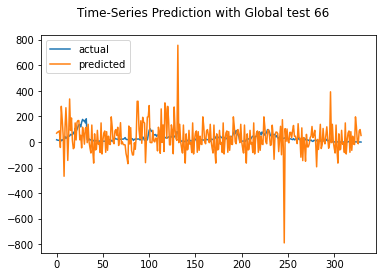

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 73.370
Test RMSE: 91.659
Test sMAPE: 118.928
Test R Squared: -7.693
{'mae': 73.37042259447503, 'rmse': 91.65851948440388, 'smape': 118.92803379398902, 'r2': -7.693360263603676}


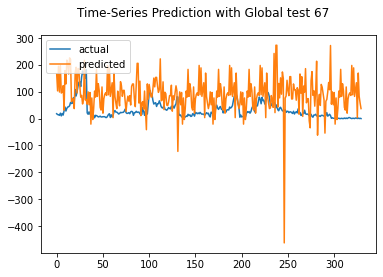

Test MAE: 76.197
Test RMSE: 99.039
Test sMAPE: 115.764
Test R Squared: -9.150
{'mae': 76.19718326366309, 'rmse': 99.03942304283736, 'smape': 115.76443025300298, 'r2': -9.149816836352242}


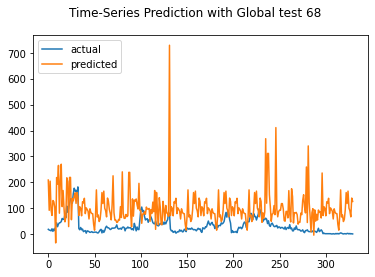

Test MAE: 76.671
Test RMSE: 105.072
Test sMAPE: 119.062
Test R Squared: -10.424
{'mae': 76.67095519846136, 'rmse': 105.0717827316593, 'smape': 119.06221917861282, 'r2': -10.423895019480451}


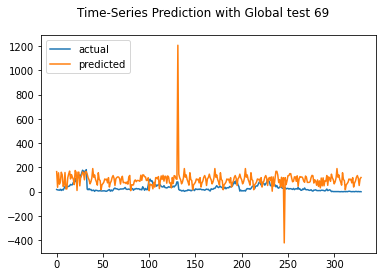

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 79.343
Test RMSE: 103.044
Test sMAPE: 136.089
Test R Squared: -9.987
{'mae': 79.34315947294235, 'rmse': 103.0439321351417, 'smape': 136.08943940115697, 'r2': -9.987195381750904}


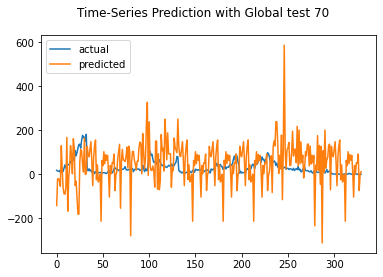

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.919
Test RMSE: 55.690
Test sMAPE: 107.099
Test R Squared: -2.209
{'mae': 46.91892438368364, 'rmse': 55.68982113009774, 'smape': 107.09856119558894, 'r2': -2.209176827490421}


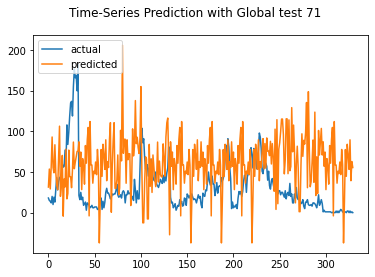

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 40.251
Test RMSE: 52.209
Test sMAPE: 105.727
Test R Squared: -1.821
{'mae': 40.25135571956635, 'rmse': 52.208672745707354, 'smape': 105.72663934470292, 'r2': -1.8205078124726901}


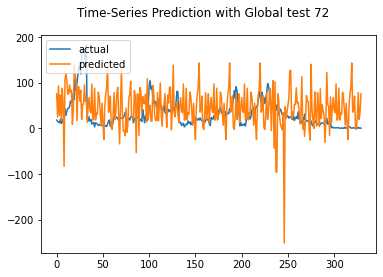

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 81.558
Test RMSE: 156.571
Test sMAPE: 134.859
Test R Squared: -24.367
{'mae': 81.55843520119335, 'rmse': 156.57120854110363, 'smape': 134.8592701577339, 'r2': -24.36680727187657}


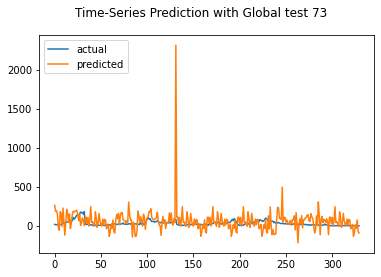

Test MAE: 67.026
Test RMSE: 99.648
Test sMAPE: 131.742
Test R Squared: -9.275
{'mae': 67.02587104782914, 'rmse': 99.64771447249373, 'smape': 131.74159174701288, 'r2': -9.274878284199392}


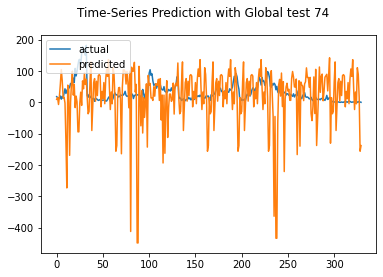

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 45.385
Test RMSE: 62.931
Test sMAPE: 116.109
Test R Squared: -3.098
{'mae': 45.385388846830885, 'rmse': 62.93147813558655, 'smape': 116.10865014347611, 'r2': -3.098055793194532}


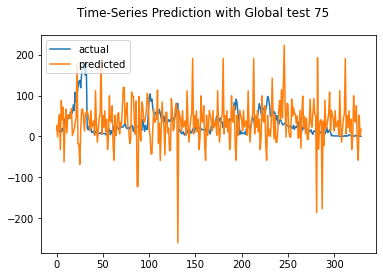

Test MAE: 69.844
Test RMSE: 94.582
Test sMAPE: 143.899
Test R Squared: -8.257
{'mae': 69.84354445500807, 'rmse': 94.5820791707597, 'smape': 143.8991437259169, 'r2': -8.256775159979696}


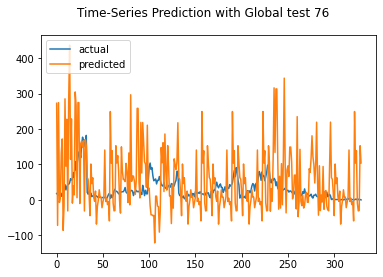

Test MAE: 53.032
Test RMSE: 282.294
Test sMAPE: 98.070
Test R Squared: -81.460
{'mae': 53.03173718362144, 'rmse': 282.2941484094415, 'smape': 98.07033343201651, 'r2': -81.46046005143234}


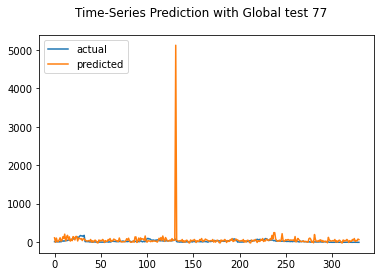

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 62.725
Test RMSE: 85.485
Test sMAPE: 132.328
Test R Squared: -6.562
{'mae': 62.725432739835796, 'rmse': 85.48488314533088, 'smape': 132.3280268497043, 'r2': -6.561720947059215}


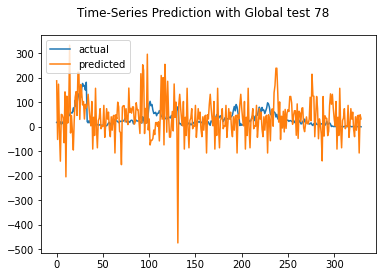

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 81.715
Test RMSE: 123.769
Test sMAPE: 130.497
Test R Squared: -14.851
{'mae': 81.71477033152725, 'rmse': 123.76925303084744, 'smape': 130.49686152836696, 'r2': -14.851396942117743}


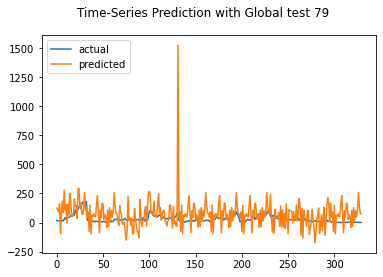

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 55.653
Test RMSE: 112.592
Test sMAPE: 113.591
Test R Squared: -12.118
{'mae': 55.65278357285442, 'rmse': 112.59215259226892, 'smape': 113.59143604766312, 'r2': -12.11771666618907}


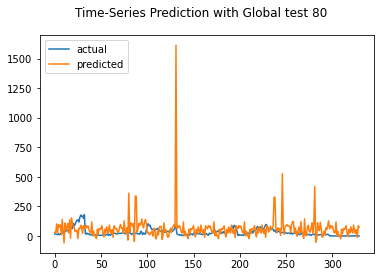

Test MAE: 43.036
Test RMSE: 63.945
Test sMAPE: 96.700
Test R Squared: -3.231
{'mae': 43.0361921079231, 'rmse': 63.944837740623335, 'smape': 96.70021646840686, 'r2': -3.2310969919587764}


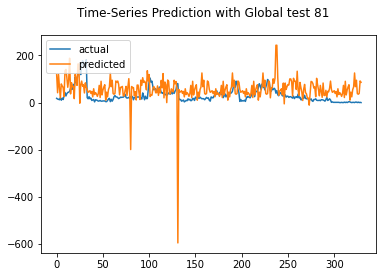

Test MAE: 59.885
Test RMSE: 76.654
Test sMAPE: 116.893
Test R Squared: -5.080
{'mae': 59.88540926304731, 'rmse': 76.65417653816617, 'smape': 116.89279138792395, 'r2': -5.080140944231908}


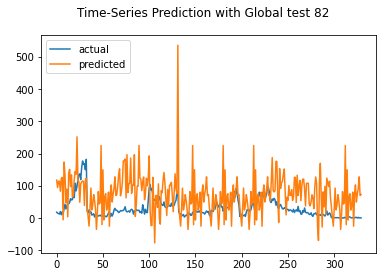

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 50.421
Test RMSE: 70.570
Test sMAPE: 112.951
Test R Squared: -4.153
{'mae': 50.42067451404803, 'rmse': 70.56961373874242, 'smape': 112.95072094953291, 'r2': -4.153205745630073}


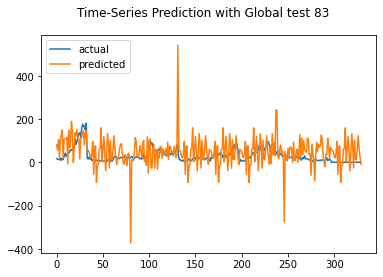

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 42.988
Test RMSE: 89.299
Test sMAPE: 114.328
Test R Squared: -7.252
{'mae': 42.987714478825076, 'rmse': 89.29943012360462, 'smape': 114.32752455922312, 'r2': -7.251622975769342}


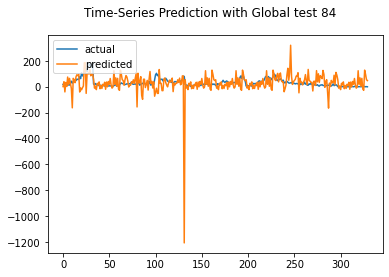

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 54.268
Test RMSE: 73.857
Test sMAPE: 129.906
Test R Squared: -4.644
{'mae': 54.26816055458603, 'rmse': 73.85654960668553, 'smape': 129.90624442241872, 'r2': -4.644429213404345}


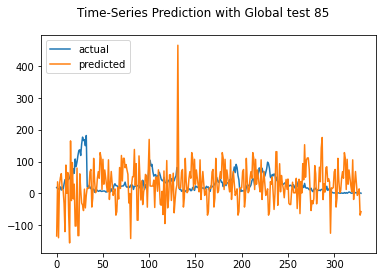

Test MAE: 68.567
Test RMSE: 91.863
Test sMAPE: 127.335
Test R Squared: -7.732
{'mae': 68.5670979124127, 'rmse': 91.86336387623489, 'smape': 127.33489786373644, 'r2': -7.73226065200636}


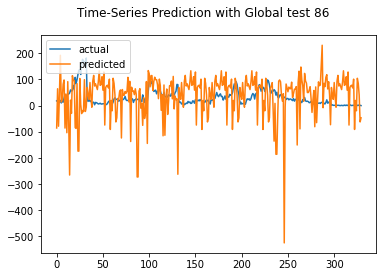

Test MAE: 86.489
Test RMSE: 184.795
Test sMAPE: 127.749
Test R Squared: -34.336
{'mae': 86.48917720372026, 'rmse': 184.79460248219212, 'smape': 127.74898445124528, 'r2': -34.33625870896582}


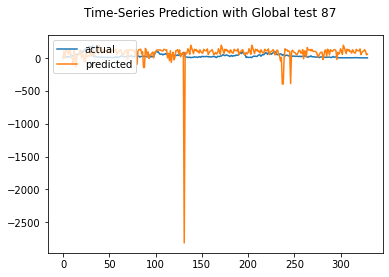

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 51.053
Test RMSE: 75.246
Test sMAPE: 101.486
Test R Squared: -4.859
{'mae': 51.05337309114861, 'rmse': 75.24629677001968, 'smape': 101.48557175561574, 'r2': -4.858848443433052}


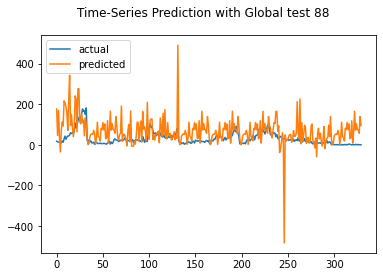

Test MAE: 52.449
Test RMSE: 69.027
Test sMAPE: 105.224
Test R Squared: -3.930
{'mae': 52.44937135089528, 'rmse': 69.0271398432045, 'smape': 105.22388737923318, 'r2': -3.9303955073291776}


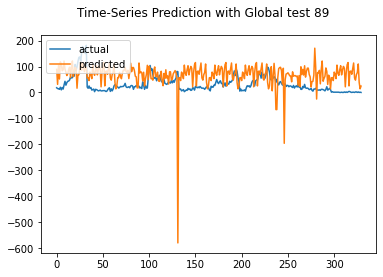

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 51.313
Test RMSE: 66.975
Test sMAPE: 115.561
Test R Squared: -3.642
{'mae': 51.31340793949185, 'rmse': 66.97534963737756, 'smape': 115.56054967828211, 'r2': -3.6416456275287112}


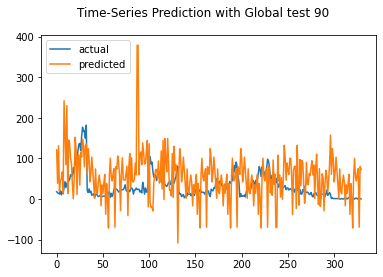

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 35.345
Test RMSE: 47.387
Test sMAPE: 102.097
Test R Squared: -1.324
{'mae': 35.34488321795608, 'rmse': 47.387421750539666, 'smape': 102.097481077484, 'r2': -1.3236363525638608}


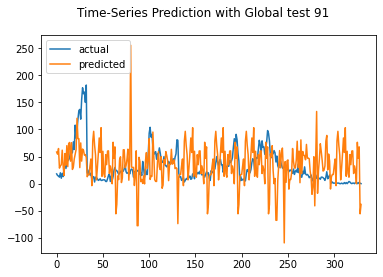

Test MAE: 87.071
Test RMSE: 124.979
Test sMAPE: 121.105
Test R Squared: -15.163
{'mae': 87.07101796829339, 'rmse': 124.9793530877234, 'smape': 121.10514881915786, 'r2': -15.16287247595496}


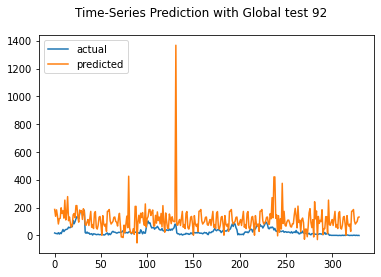

Test MAE: 88.557
Test RMSE: 122.095
Test sMAPE: 136.574
Test R Squared: -14.425
{'mae': 88.55739739880417, 'rmse': 122.09486872973989, 'smape': 136.57354618289634, 'r2': -14.425413907421497}


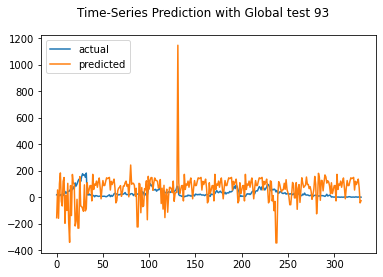

Test MAE: 41.472
Test RMSE: 61.199
Test sMAPE: 99.127
Test R Squared: -2.876
{'mae': 41.47185778726231, 'rmse': 61.19945721361244, 'smape': 99.1270226665133, 'r2': -2.875583893471939}


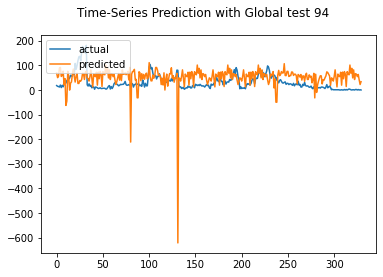

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.755
Test RMSE: 55.794
Test sMAPE: 116.913
Test R Squared: -2.221
{'mae': 40.75522137130752, 'rmse': 55.79356901800131, 'smape': 116.91308162531548, 'r2': -2.221145098992808}


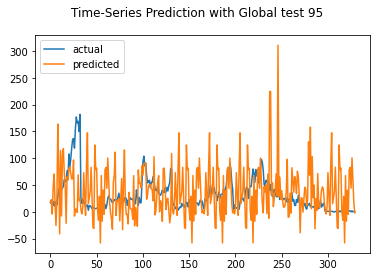

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 57.395
Test RMSE: 76.266
Test sMAPE: 113.231
Test R Squared: -5.019
{'mae': 57.39539739092191, 'rmse': 76.26612049372446, 'smape': 113.23131734164922, 'r2': -5.018736248026644}


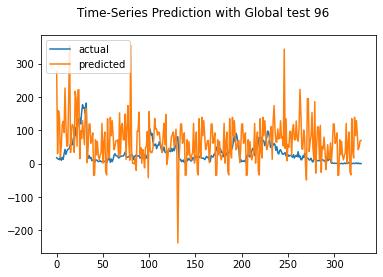

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 38.631
Test RMSE: 54.872
Test sMAPE: 107.365
Test R Squared: -2.116
{'mae': 38.63131870744807, 'rmse': 54.871763500086374, 'smape': 107.36539016561689, 'r2': -2.115586674773231}


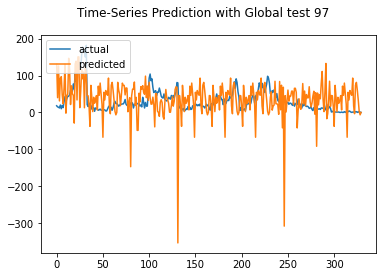

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 46.754
Test RMSE: 63.167
Test sMAPE: 133.598
Test R Squared: -3.129
{'mae': 46.75398986285383, 'rmse': 63.16660136773027, 'smape': 133.59821883106537, 'r2': -3.1287351335204194}


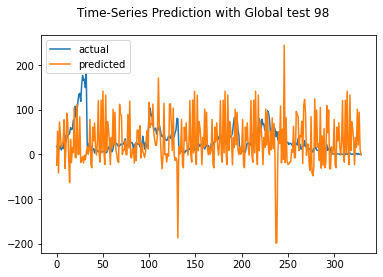

Test MAE: 60.715
Test RMSE: 118.374
Test sMAPE: 112.637
Test R Squared: -13.500
{'mae': 60.71498659776919, 'rmse': 118.3741254649912, 'smape': 112.63718046384808, 'r2': -13.499584880515595}


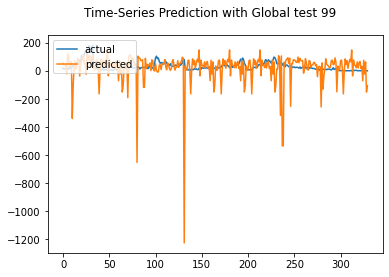

rmse : average=101.642, std=44.710
mae : average=65.181, std=18.666
smape : average=120.836, std=14.319
r2 : average=-11.759, std=13.596


([101.6424774527483, 44.71048484098633],
 [65.18125379665061, 18.666365894191703],
 [120.83622668133583, 14.318644104547733],
 [-11.758888760651523, 13.595814517682875])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')